In [428]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [430]:
df = pd.read_csv("diabetes.csv")
print(df)

     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6      148             72             35        0  33.6   
1              1       85             66             29        0  26.6   
2              8      183             64              0        0  23.3   
3              1       89             66             23       94  28.1   
4              0      137             40             35      168  43.1   
..           ...      ...            ...            ...      ...   ...   
763           10      101             76             48      180  32.9   
764            2      122             70             27        0  36.8   
765            5      121             72             23      112  26.2   
766            1      126             60              0        0  30.1   
767            1       93             70             31        0  30.4   

     DiabetesPedigreeFunction  Age  Outcome  
0                       0.627   50        1  
1                  

In [432]:
traducao_colunas = {
    'Pregnancies': 'Gravidezes'
    ,'Glucose': 'Glicose'
    ,'BloodPressure': 'Pressão_Arterial'
    ,'SkinThickness': 'Espessura_da_Pele'
    ,'Insulin': 'Insulina'
    ,'BMI': 'IMC'
    ,'DiabetesPedigreeFunction': 'Histórico_Familiar'
    ,'Age': 'Idade'
    ,'Outcome': 'Diabete'
}
df.rename(columns=traducao_colunas, inplace=True)
print(df.columns)

Index(['Gravidezes', 'Glicose', 'Pressão_Arterial', 'Espessura_da_Pele',
       'Insulina', 'IMC', 'Histórico_Familiar', 'Idade', 'Diabete'],
      dtype='object')


In [434]:
colunas_sem_zero = ['Glicose', 'Pressão_Arterial', 'Espessura_da_Pele', 'Insulina', 'IMC']

df = df[(df[colunas_sem_zero] != 0).all(axis=1)]

In [436]:
cols_with_zero = ['Gravidezes', 'Glicose', 'Pressão_Arterial', 'Espessura_da_Pele', 'Insulina', 'IMC', 'Histórico_Familiar', 'Idade']
for col in cols_with_zero:
    print(f'{col}: {df[col].value_counts().get(0, 0)} valores zero')

Gravidezes: 56 valores zero
Glicose: 0 valores zero
Pressão_Arterial: 0 valores zero
Espessura_da_Pele: 0 valores zero
Insulina: 0 valores zero
IMC: 0 valores zero
Histórico_Familiar: 0 valores zero
Idade: 0 valores zero


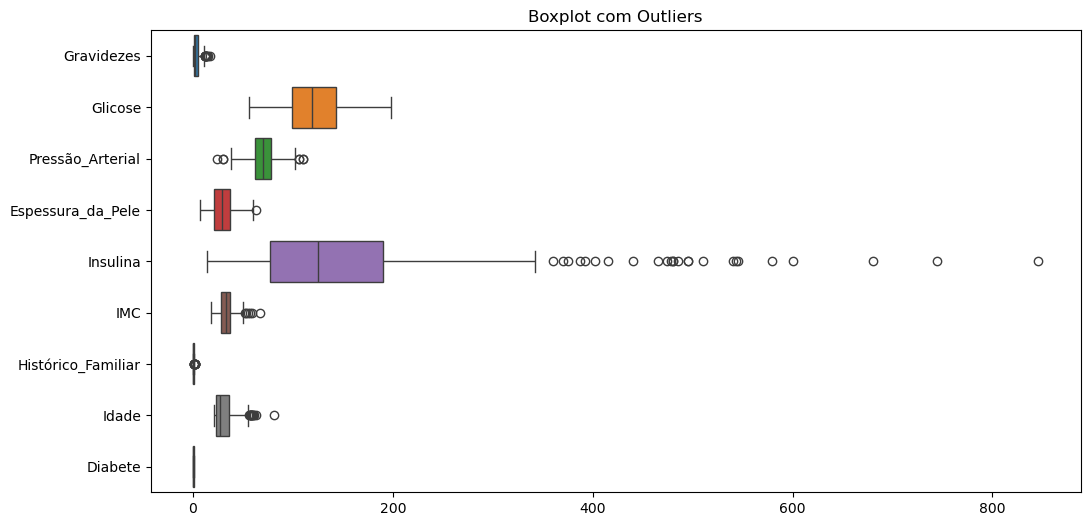

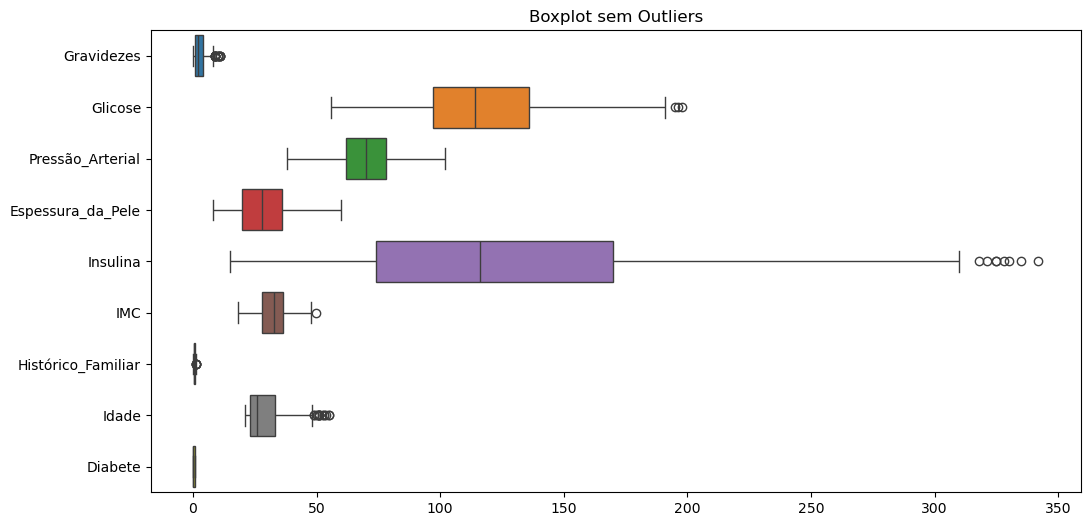

In [438]:
def detectar_outliers_iqr_indices(df):
    outlier_indices = {}
    for col in df.select_dtypes(include='number').columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR
        outlier_mask = (df[col] < limite_inferior) | (df[col] > limite_superior)
        outlier_indices[col] = df[outlier_mask].index.tolist()
    return outlier_indices

outliers_por_coluna = detectar_outliers_iqr_indices(df)

todos_outliers = set()
for indices in outliers_por_coluna.values():
    todos_outliers.update(indices)

df_sem_outliers = df.drop(index=todos_outliers).reset_index(drop=True)

plt.figure(figsize=(12, 6))
sns.boxplot(data=df, orient='h')
plt.title("Boxplot com Outliers")
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_sem_outliers, orient='h')
plt.title("Boxplot sem Outliers")
plt.show()

In [440]:
print(df.describe())

       Gravidezes     Glicose  Pressão_Arterial  Espessura_da_Pele  \
count  392.000000  392.000000        392.000000         392.000000   
mean     3.301020  122.627551         70.663265          29.145408   
std      3.211424   30.860781         12.496092          10.516424   
min      0.000000   56.000000         24.000000           7.000000   
25%      1.000000   99.000000         62.000000          21.000000   
50%      2.000000  119.000000         70.000000          29.000000   
75%      5.000000  143.000000         78.000000          37.000000   
max     17.000000  198.000000        110.000000          63.000000   

         Insulina         IMC  Histórico_Familiar       Idade     Diabete  
count  392.000000  392.000000          392.000000  392.000000  392.000000  
mean   156.056122   33.086224            0.523046   30.864796    0.331633  
std    118.841690    7.027659            0.345488   10.200777    0.471401  
min     14.000000   18.200000            0.085000   21.000000    

In [442]:
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

X = df.drop('Diabete', axis=1)
y = df['Diabete']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

X_const = sm.add_constant(X_scaled_df)

model = sm.Logit(y, X_const)
result = model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.438803
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                Diabete   No. Observations:                  392
Model:                          Logit   Df Residuals:                      383
Method:                           MLE   Df Model:                            8
Date:                Tue, 04 Nov 2025   Pseudo R-squ.:                  0.3093
Time:                        20:21:44   Log-Likelihood:                -172.01
converged:                       True   LL-Null:                       -249.05
Covariance Type:            nonrobust   LLR p-value:                 2.765e-29
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -1.0003      0.143     -6.981      0.000      -1.281      -0.719
Gravi

In [444]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix


X = df.drop('Diabete', axis=1)
y = df['Diabete']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=42)
model.fit(X_train_scaled, y_train)

y_prev = model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_prev)
report = classification_report(y_test, y_prev)

print(accuracy)
print(report)
print(confusion_matrix(y_test, y_prev))

0.8227848101265823
              precision    recall  f1-score   support

           0       0.93      0.79      0.86        53
           1       0.68      0.88      0.77        26

    accuracy                           0.82        79
   macro avg       0.80      0.84      0.81        79
weighted avg       0.85      0.82      0.83        79

[[42 11]
 [ 3 23]]


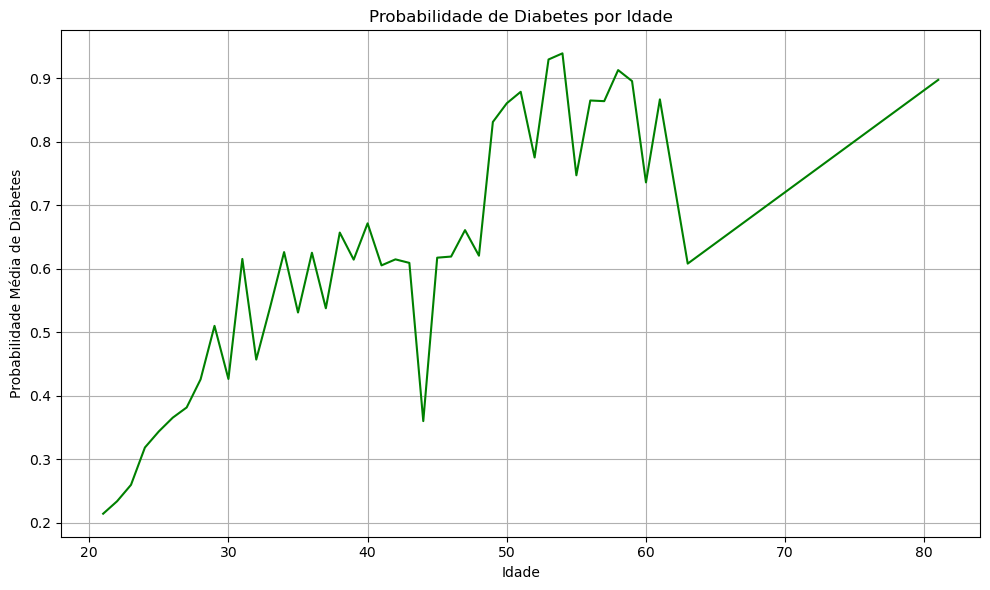

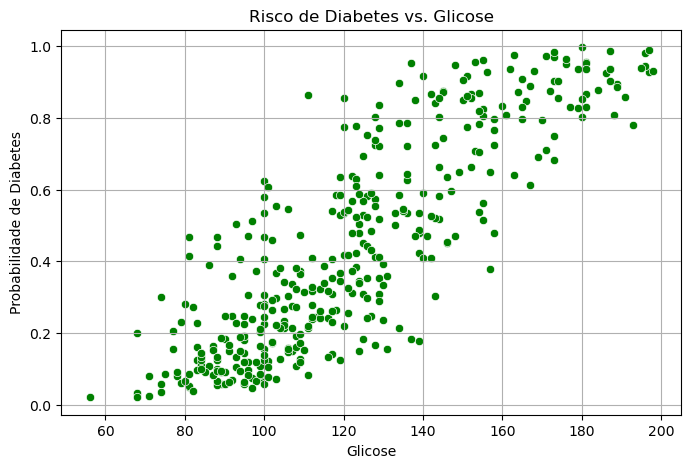

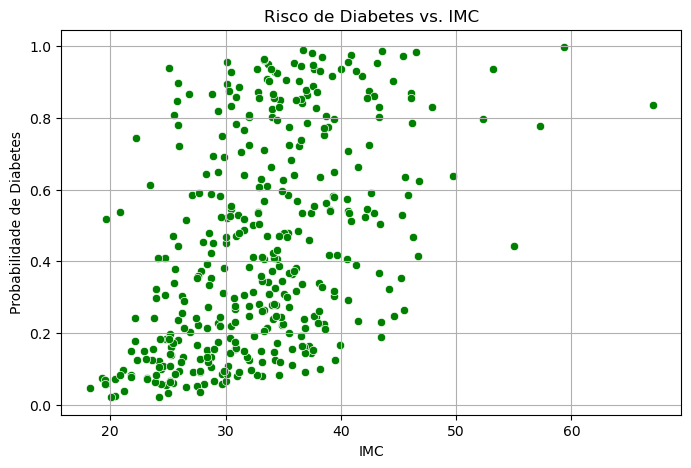

In [446]:
probabilidades = model.predict_proba(X_scaled)[:, 1]

df_prob = pd.DataFrame({'Idade': df['Idade'], 'Probabilidade': probabilidades})
df_grouped = df_prob.groupby('Idade').mean().reset_index()
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_grouped, x='Idade', y='Probabilidade', color='green')
plt.title('Probabilidade de Diabetes por Idade')
plt.xlabel('Idade')
plt.ylabel('Probabilidade Média de Diabetes')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
sns.scatterplot(x=df['Glicose'], y=probabilidades, color='green')
plt.title('Risco de Diabetes vs. Glicose')
plt.xlabel('Glicose')
plt.ylabel('Probabilidade de Diabetes')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
sns.scatterplot(x=df['IMC'], y=probabilidades, color='green')
plt.title('Risco de Diabetes vs. IMC')
plt.xlabel('IMC')
plt.ylabel('Probabilidade de Diabetes')
plt.grid(True)
plt.show()